In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
import glob
from skimage.io import imread, imshow
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

# Exploratory Data Analysis

In [ ]:
## Loading NIH data

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head(10)

Filtering records of "Patient Age" those are less than are equal to 100 years as the X-ray images of Pateient over 100 year may not be relevant for training and testing the dataset. There are 16 records having anamoly in Patient Age" over 100 years

In [ ]:
## filtering records of "Patient Age" 

all_xray_df = all_xray_df[all_xray_df['Patient Age']<=100]
all_xray_df.head(10)

In [ ]:
## "Patient Age" Group Distribution in the Dataset

plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], color='y', edgecolor='g')

In [ ]:
## "Patient Gender" distribution in the Dataset

plt.figure(figsize=(6,6))
color =['g', 'b']
all_xray_df['Patient Gender'].value_counts().plot(kind='bar', color=color, edgecolor='g')
all_xray_df['Patient Gender'].value_counts()

In [ ]:
## X-Ray "View Positions" in the Dataset

plt.figure(figsize=(6,6))
color =['g', 'b']
all_xray_df['View Position'].value_counts().plot(kind='bar', color=color, edgecolor='g')
all_xray_df['View Position'].value_counts()

Now, I'm splitting "Finding Labels" column so as to have one column in the dataframe per disease, with a binary flag for EDA 


In [ ]:
# Splitting "Finding Labels" column 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.head(10)

In [ ]:
## % of findings of each disease

round(((all_xray_df[all_labels].sum()/len(all_xray_df)).sort_values(ascending=False))*100,2)

In [ ]:
## Number of findings of each disease
plt.figure(figsize=(10,6))
color =['r', 'g', 'b', 'y', 'w']
ax = all_xray_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar', color=color, edgecolor='g')
all_xray_df[all_labels].sum().sort_values(ascending=False)

We can see the relative frequencies of each disease in NIH dataset. 60353(53.8%) of the chest X-ray does not have any obervation of diseseas and it is marked as 'No Finding' 

'Infiltration' is the most common disease having 19891(17.7%) followed by 'Effusion' having 13316(11.8%), 'Atelectasis' having 11558(10.3%) and so on. Presnece of 'Pneumonia' is just 1430(1.27%) 

In [ ]:
## Filering records with "No Findings" as there records is not of use for further EDA

all_xray_df = all_xray_df[all_xray_df['No Finding']==0]
all_xray_df.sample(10)

In [ ]:
## Number of Patient having Pneumonia

plt.figure(figsize=(6,6))
labels=['No Pneumonia', 'Pneumonia'] 
colors =['y', 'g']
(all_xray_df.Pneumonia==1).value_counts().plot(kind='pie', labels=labels, colors= colors)
(all_xray_df.Pneumonia==1).value_counts().values

In [ ]:
## Number of Patient having disease other than Pneumonia 

plt.figure(figsize=(6,6))
labels=['No Pneumonia', 'Pneumonia'] 
colors =['g', 'y']
(all_xray_df.Pneumonia==0).value_counts().plot(kind='pie', labels=labels, colors= colors)
(all_xray_df.Pneumonia==0).value_counts()

In [ ]:
## Age group of patient having Pneumonia

plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], color='y', edgecolor='g')

In [ ]:
## Age group of patient having disceses other than Pneumonia

plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==0]['Patient Age'], color='y', edgecolor='g')

In [ ]:
##Pneumonia co-occurrences with 30 most other disease 

plt.figure(figsize=(16,6))
color =['r', 'g', 'b', 'y', 'w']
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar', color=color, edgecolor='g')
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30]

In [ ]:
# Number of disease per patient along with Pneumonia 

plt.figure(figsize=(16,6))
color =['r', 'g', 'b', 'y', 'w']
all_xray_df[all_labels].where(all_xray_df.Pneumonia==1).sum().sort_values(ascending=False).plot(kind='bar', color=color, edgecolor='g')
all_xray_df[all_labels].where(all_xray_df.Pneumonia==1).sum().sort_values(ascending=False)

# Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [2]:
## Reading DICOM files 

chest_xray_dicoms = glob.glob("*.dcm")

Creating the dataframe and populating it in a loop with all the DICOMS

In [3]:
## Extracting data from DICOM file

all_chest_xray = []

for i in chest_xray_dicoms: 
    chest_xray_dcm = pydicom.dcmread(i)
    fields = [chest_xray_dcm.PatientID, int(chest_xray_dcm.PatientAge), chest_xray_dcm.PatientSex, 
              chest_xray_dcm.Modality, chest_xray_dcm.StudyDescription,
             chest_xray_dcm.Rows, chest_xray_dcm.Columns]
    all_chest_xray.append(fields)

In [4]:
## Creating Dataframe from extracted data from DIOCM file

chest_xray_data = pd.DataFrame(all_chest_xray, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [ ]:
## Read Dataframe created from DICOM file

chest_xray_data

In [5]:
# Capturing starting and ending values of rows

start = chest_xray_data.index.start
stop = chest_xray_data.index.stop

Image Visualiziation using plt.imshow

Patient ID - 1 , Findings - Cardiomegaly


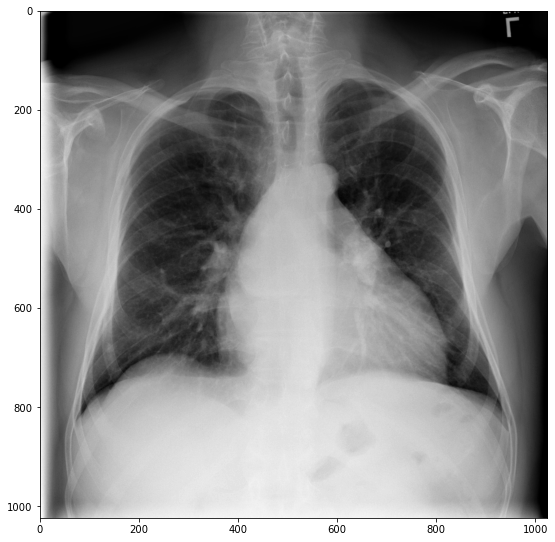

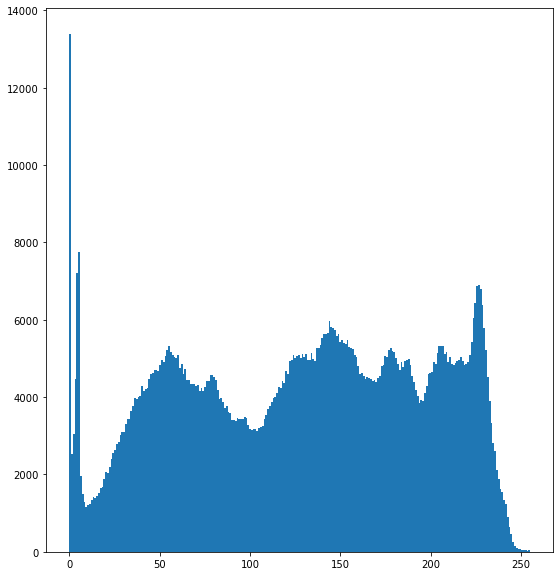

Patient ID - 2 , Findings - No Finding


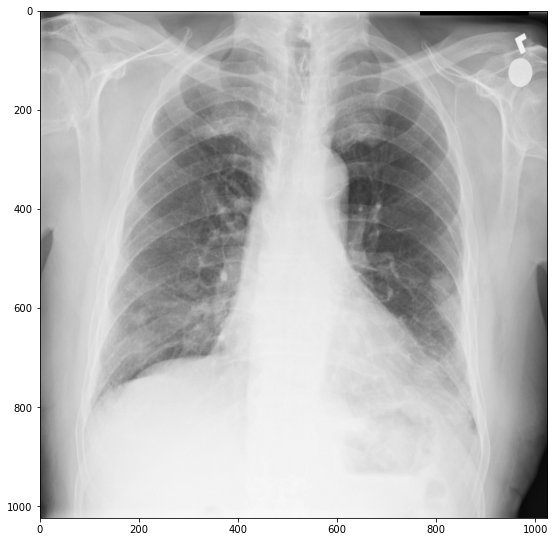

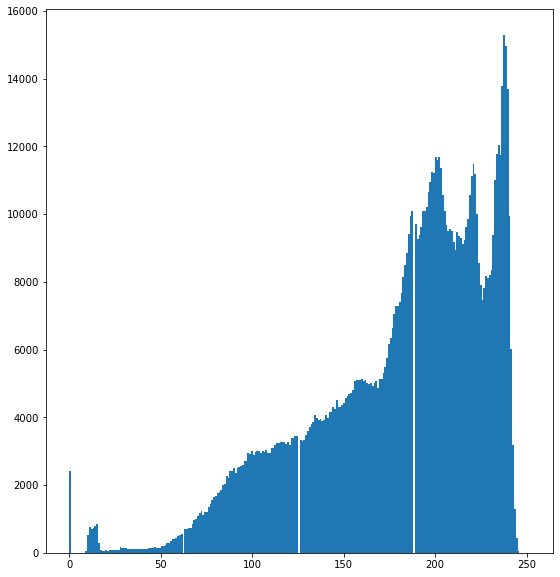

Patient ID - 2 , Findings - No Finding


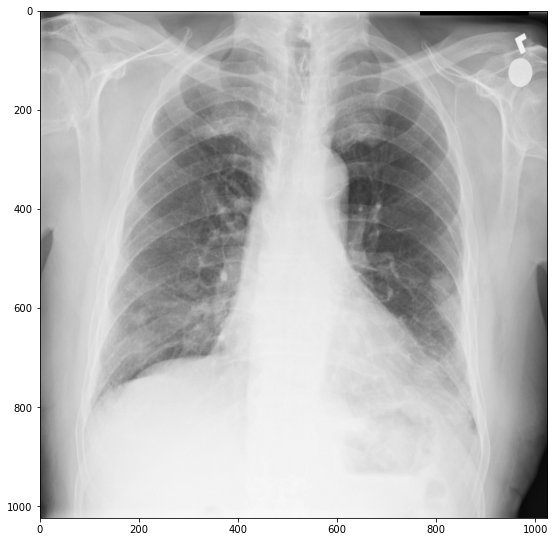

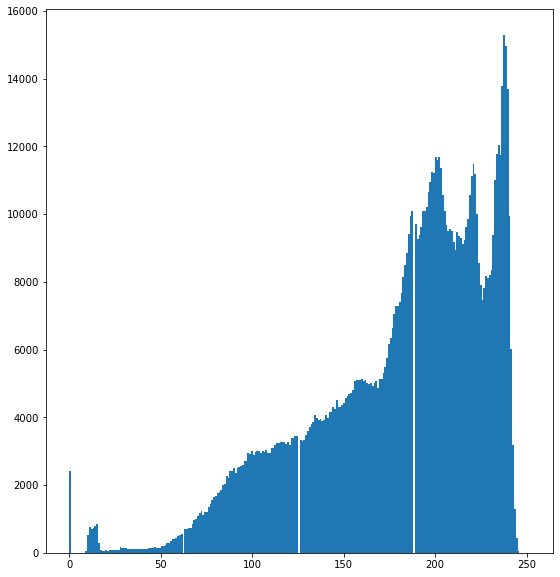

Patient ID - 2 , Findings - No Finding


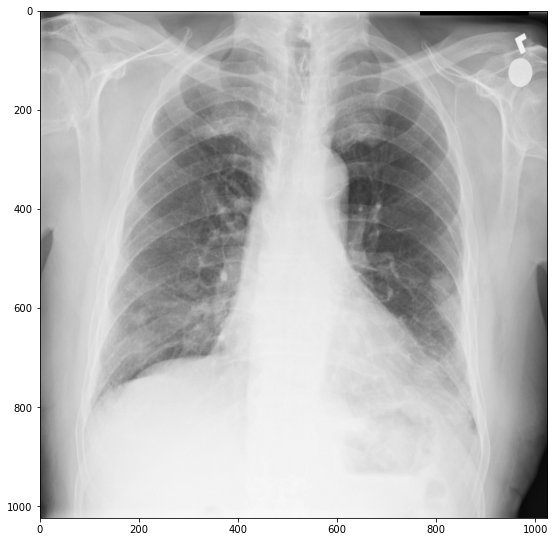

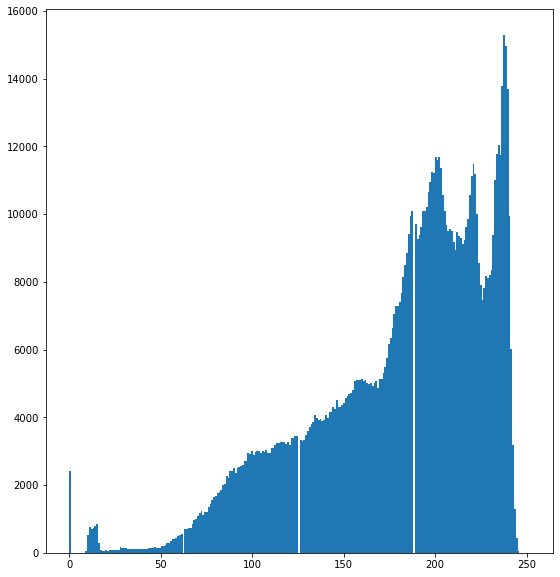

Patient ID - 2 , Findings - No Finding


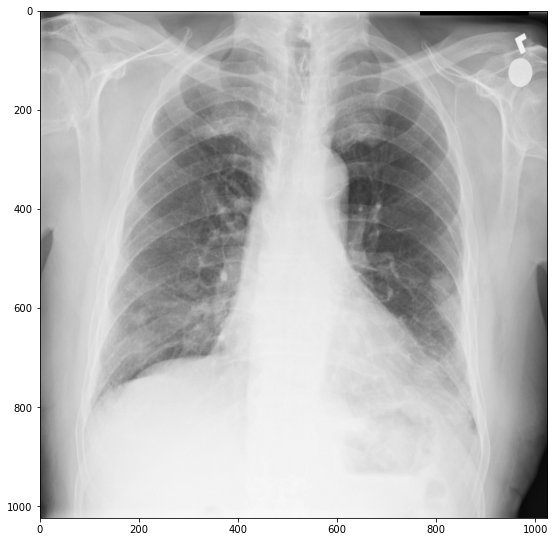

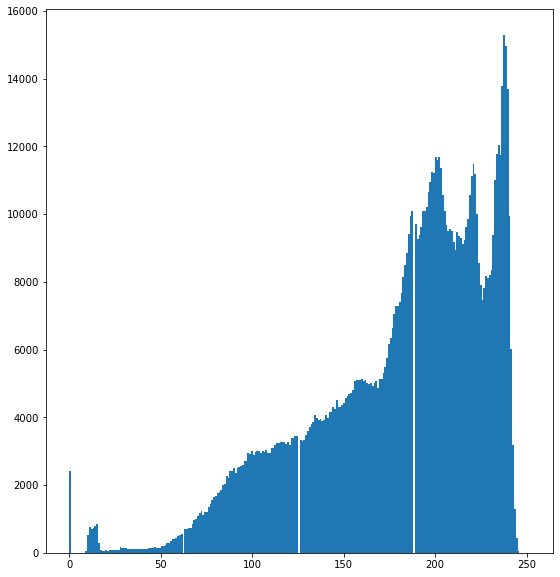

Patient ID - 61 , Findings - Effusion


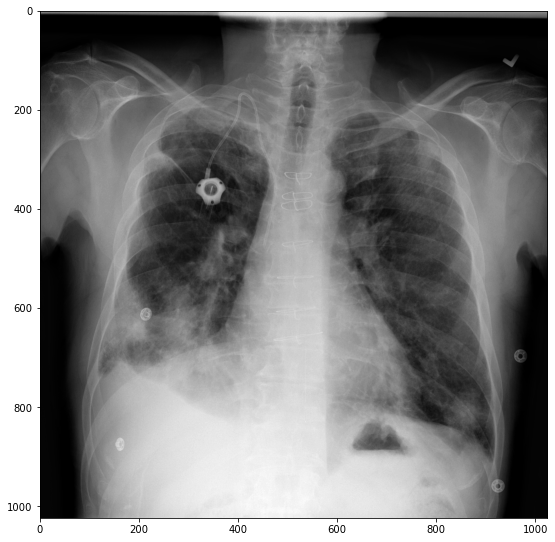

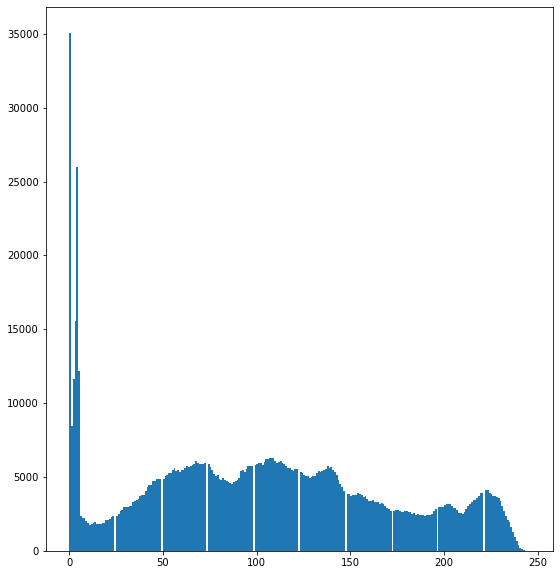

In [26]:
# Reading the X-ray image and plotting

for i in range(start,stop):
    chest_xray_image = pydicom.dcmread(chest_xray_dicoms[i])   
    print('Patient ID -', chest_xray_image.PatientID,',', 'Findings -', chest_xray_image.StudyDescription)
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(chest_xray_image.pixel_array[:, :], cmap='gray')
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,2)
    plt.hist(chest_xray_image.pixel_array.ravel(), bins = 256)
    plt.show(block=True)

From the provided X-ray image dataset, we can conclude that close to 54% of x-ray images does not have any disease and the balance 47% have 14 types of disease with Pneumonia having just 1.28%. So the training and test set will be split into 80% for training and 20% for testing in a similar proportion to No Findings and each disease. We should ensure, that image used in training is not used for testing the model